In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

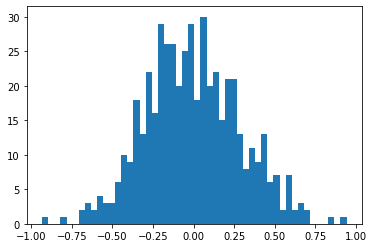

In [11]:
# https://stackoverflow.com/questions/36894191/how-to-get-a-normal-distribution-within-a-range-in-numpy
def get_truncated_normal(mean=0, sd=0.3, low=-1, upp=1):
    return truncnorm(
        (low - mean)/sd, 
        (upp - mean)/sd, 
        loc = mean, 
        scale = sd)

X = get_truncated_normal()
plt.hist(X.rvs(500), bins = 50)
plt.show()

In [12]:
class post:
    
    def __init__(self, user_id, kind, user_ideology, user_trust):
        self.type = kind   # binary: either post (1) or comment (0)
        self.author = user_id
        
        # post's ideology score
        self.ideology = get_truncated_normal(mean=user_ideology, sd=0.2, low=-1, upp=1).rvs()  
        
        # post's trustworthiness
        self.trust = get_truncated_normal(mean=user_trust, sd=0.1, low=0, upp=1).rvs()  

In [282]:
class user:
    def __init__(self):
        self.ideology = get_truncated_normal(mean=0, sd=0.3, low=-1, upp=1).rvs()
        # care value is dependent on the absolute value of ideology value of the user + noise,
        # on the assumption based on research that reveals people with more radial political leanings tend to be more engaging
        self.care = get_truncated_normal(mean=abs(self.ideology), sd = 0.15, low = 0, upp=1).rvs()
        self.trust = get_truncated_normal(mean=0.5, sd=0.15, low=0, upp=1).rvs()   # post's trustworthiness
        
        # how easy a user will be influenced/persuaded by a post
        self.easiness = get_truncated_normal(mean=0.5, sd = 0.15, low = 0, upp=1).rvs()
        
def create_n_users (n):
    user_list = []
    for i in range(n):
        user_list.append(user())
    return user_list

In [283]:
def create_posts(users):
    post_list = []
    for j in range(len(users)):
        user = users[j]
        num_posts = int(round((abs(user.ideology)*10)+(user.care*10), 0))
        for i in range(num_posts):
            post_list.append(post(j, 1, user.ideology, user.trust))
        #print(num_posts, user.care, user.ideology)
    return post_list

user_list = create_n_users(100)
post_list = create_posts(user_list)

#user_idx = 0
#for i in range(len(user_list)):
  #print("===== User", i, "=====")
  #num_posts = int(round((abs(user_list[i].ideology)*10)+(user_list[i].care*10), 0))
  #print("user's ideology score: ", user_list[i].ideology, ", user's care score: ", user_list[i].care, "# posts:", num_posts)

  #for j in range(num_posts):
  #  post_list.append(post(i, 1, user_list[i].ideology, user_list[i].trust))
  #  print("post", j, ": author =", post_list[-1].author, 
  #        ", post's ideology score =", post_list[-1].ideology, 
  #        ", post's trust score =", post_list[-1].trust)
  
  #print()

0.14529221848190776 0.2601122891454502 0.11482007066354244 0.5044100156051529
0.17692180987021172
0.24377064762194833


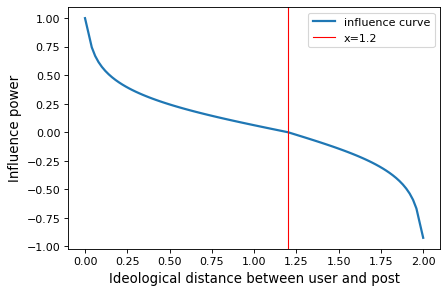

In [393]:
import math

# cutoff_point: when the ideology distance is greater than 1+notwork_point,
#   the user's ideology will be pulled further away from the post's ideology
# I use the formula below to make the influence effect between -1 and 1.
#   ref: https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
def logit(x, cutoff_pt=1.2, offset_power=2):
    if(x == 0):
        x = x+10**(-offset_power)
    elif(x == 2):
        x = x-10**(-offset_power)
        
    if(x <= cutoff_pt):
        x = (x/cutoff_pt)/2
    else:
        x = (((x-cutoff_pt)/(2-cutoff_pt))+1)/2
    
    return -math.log(x/(1-x))

# I use the formula below to make the influence effect between -1 and 1.
#   ref: https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
def normalize(value):
    max_value = logit(0)
    #min_value = logit(2)
    min_value = -max_value
    
    return_value = 2*((logit(value) - min_value)/(max_value - min_value)) -1
    if(return_value > 1):
        return 1
    elif(return_value < -1):
        return -1
    else:
        return return_value

# calculate how each post the user has read will affect the user's ideology
# - the affect power is inverse proportional to the distance between the user's and the post's ideology
# - use user's easiness parameter (between 0 and 1) to tune the influence effect  
# return value: new user ideology score
def influence(user, post, tune_power=1.1, tune_denominator=0.1):
    ideology_distance = abs(user.ideology - post.ideology)
    influence_ratio = user.easiness * normalize(ideology_distance)
    new_user_ideology = user.ideology - influence_ratio*(user.ideology - post.ideology)
    return new_user_ideology

# for testing purpose
x = []
for i in range(101):
    x.append(i*2/100)
    
y = []
for i in range(101):
    y.append(normalize(x[i]))

plt.figure(figsize=(6, 4), dpi=80)
plt.xlabel("Ideological distance between user and post", fontsize=12)
plt.ylabel("Influence power", fontsize=12)
plt.plot(x, y, linewidth=2.0, label="influence curve")
plt.axvline(x=1.2, color="red", linewidth=1.0, label="x=1.2")
plt.legend()

print(user_list[0].ideology, 
      post_list[0].ideology, 
      abs(user_list[0].ideology - post_list[0].ideology),
      user_list[0].easiness)
print(influence(user_list[0], post_list[0]))
print(normalize(0.5))

In [15]:
def recommend_n_by_user_post (posts, users, n):
    #aggregate each post.ideology by users
    user_all_posts = {}
    for post in posts:
        if post.author not in user_all_posts.keys():
            user_all_posts[post.author] = []
        user_all_posts[post.author].append(post.ideology)
        
    #populate the user - ideology mean dictionary
    user_ideology_from_posts = {}
    for user in range(len(users)):
        if user in user_all_posts.keys():
            user_ideology_from_posts[user] = sum(user_all_posts[user])/len(user_all_posts[user])
        else:
            user_ideology_from_posts[user] = 0
            
    recommended_posts = {}
    for user in range(len(users)):
        diff = {}
        for post in posts:
            if not post.author == user:
                diff[post] = abs(user_ideology_from_posts[user] - post.ideology)
        new_diff = dict(sorted(diff.items(), key = lambda item: item[1]))
        result = list(new_diff.keys())
        new_result = []
        for i in range(n):
            #print(diff[result[i]])
            new_result.append(result[i])
        recommended_posts[user] = new_result
    return recommended_posts